In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import time
import torch.optim as optim
# from submodel import *
import wfdb
from collections import defaultdict
import numpy as np
import sys
import os 
import matplotlib.pyplot as plt
import biosppy.signals.ecg as ecg_preprocessing
import pywt
import pandas as pd

In [5]:
with open('1.txt','r') as f:
    for m in f.read(2):
        print(m)
    print(len(f.read()))

a
b
15


In [6]:
# 去噪相关函数
def fix_thre(coeffs = None):
    '''
    fix_thre(coeffs = None)

    Wavelet transform fixed threshold

    coeffs: Wavelet coefficients

    return--> The threshold value(a numpy array)
    '''
    res = []
    sigma = np.std(coeffs[-1])
    for i in range(len(coeffs)):
        thre = np.zeros(len(coeffs[i]))
        thre[:] = np.sqrt(2 * np.log(len(coeffs[i]))) * sigma
        res.append(thre)
    return np.array(res, dtype='object')


def min_max_thre(coeffs=None):
    '''
    min_max_thre(coeffs = None)

    Wavelet transform minimax threshold

    coeffs: Wavelet coefficients

    return--> The threshold value(a numpy array)
    '''
    res = []
    sigma = np.std(coeffs[-1])
    for i in range(len(coeffs)):
        thre = np.zeros(len(coeffs[i]))
        thre[:] = sigma * (0.3936 + 0.1829 * np.log2(len(coeffs[i]))) / 0.6745
        res.append(thre)
    return np.array(res, dtype='object')


def uni_thre(coeffs=None):
    '''
    uni_thre(coeffs = None)

    Generic thresholds for wavelet transform

    coeffs: Wavelet coefficients

    return--> The threshold value(a numpy array)
    '''
    res = []
    Mx = np.median(np.abs(coeffs[0] - np.median(coeffs[0])))
    for i in range(len(coeffs)):
        thre = np.zeros(len(coeffs[i]))
        thre[:] = np.sqrt(2 * np.log(len(coeffs[i]))) * Mx / 0.6745
        res.append(thre)
    return np.array(res, dtype='object')


def softThre(coeffs=None, thres=None):
    '''
    softThre(coeffs = None,thres = None)

    Wavelet transform soft threshold filtering
    
    coeffs: Wavelet coefficients
    thres: The threshold value

    return--> Wavelet coefficient after filtering(a numpy array)
    '''
    for coeff, thre in zip(coeffs, thres):
        for i in range(len(coeff)):
            if abs(coeff[i]) < thre[i]:
                coeff[i] = 0
            elif coeff[i] > 0:
                coeff[i] -= thre[i]
            else:
                coeff[i] += thre[i]


def artiThre(coeffs=None):
    '''
    artiThre(coeffs=None)

    Manually remove the first level of detail coefficient

    coeffs: Wavelet coefficients
    return--> Wavelet coefficient after filtering(a numpy array)
    '''
    for i in range(len(coeffs[0])):
        coeffs[0][i] = 0


def denoise(ecg,
            sampling_rate=250,
            wavelet='coif4',
            level=8,
            threselect='min_max'):
    '''
    denoise(ecg,sampling_rate=250,wavelet='coif4',level=8,threselect='min_max')

    ECG signal is filtered by wavelet transform

    ecg: ECG signal
    sampleing_rate: Sampling frequency
    wavelet: Wavelet base
    level: Decomposition level
    threselect: How the threshold value is selected

    return--> The filtered ECG signal
    '''
    if level > pywt.dwt_max_level(len(ecg), wavelet):
        level = pywt.dwt_max_level(len(ecg), wavelet)
    coeffs = pywt.wavedec(ecg, pywt.Wavelet(wavelet), level=level)
    if threselect == 'fix':
        thre = fix_thre(coeffs)
    elif threselect == 'min_max':
        thre = min_max_thre(coeffs)
    elif threselect == 'uni':
        thre = min_max_thre(coeffs)
    softThre(coeffs, thre)
    artiThre(coeffs)
    denoised_ecg = pywt.waverec(coeffs, pywt.Wavelet(wavelet))
    return np.array(denoised_ecg, dtype=np.float64)
def preprocess(ecg,
               sampling_rate=1000,
               wavelet='coif4',
               level=8,
               threselect='min_max',
               segmenter="hamilton",
               before=0.2,
               after=0.4):
    '''
    
    Args:
      
      
      
      
    
    
    preprocess(ecg, sampling_rate=1000, wavelet='coif4', level=8, threselect='min_max', segmenter="hamilton",before=0.2,after=0.4)

    Filtering for denoising, then wave peak detection, heart beat segmentation

    ecg: ECG signal
    sampleing_rate: Sampling frequency
    wavelet: Wavelet base
    level: Decomposition level
    threselect: How the threshold value is selected
    segmenter: R wave detector
    before: Take a period in front of R wave as the heart beat(unit: second)
    after: Take a period of time after R wave as heart beat(unit: second)
    '''
    filtered = denoise(ecg)
    if segmenter == "hamilton":
        rpeaks, = ecg_preprocessing.hamilton_segmenter(
            signal=filtered, sampling_rate=sampling_rate)
    elif segmenter == "gamboa":
        rpeaks, = ecg_preprocessing.gamboa_segmenter(
            signal=filtered, sampling_rate=sampling_rate, tol=0.002)
    elif segmenter == "engzee":
        rpeaks, = ecg_preprocessing.engzee_segmenter(
            signal=filtered, sampling_rate=sampling_rate, threshold=0.48)
    elif segmenter == "christov":
        rpeaks, = ecg_preprocessing.christov_segmenter(
            signal=filtered, sampling_rate=sampling_rate)
    elif segmenter == "ssf":
        rpeaks, = ecg_preprocessing.ssf_segmenter(signal=filtered,
                                                  sampling_rate=sampling_rate,
                                                  threshold=20,
                                                  before=0.03,
                                                  after=0.01)
    else:
        raise ValueError("Unknown segmenter: %s." % segmenter)
    rpeaks, = ecg_preprocessing.correct_rpeaks(signal=filtered,
                                               rpeaks=rpeaks,
                                               sampling_rate=sampling_rate,
                                               tol=0.05)

    cardiac_cycles, rpeaks = ecg_preprocessing.extract_heartbeats(
        signal=filtered,
        rpeaks=rpeaks,
        sampling_rate=sampling_rate,
        before=before,
        after=after)
    ecg_df = pd.DataFrame({"ECG_Raw": np.array(ecg)})  # Create a dataframe
    ecg_df["ECG_Filtered"] = filtered  # Add filtered signal

    # Add R peaks
    rpeaks_signal = np.array([np.nan] * len(ecg))
    rpeaks_signal[rpeaks] = 1
    ecg_df["ECG_R_Peaks"] = rpeaks_signal
    processed_ecg = {"ECG": ecg_df, "ECG_info": {"R_Peaks": rpeaks}}
    heartbeats = pd.DataFrame(cardiac_cycles).T
    heartbeats.index = np.arange(1, len(heartbeats) + 1)
    #heartbeats.index = pd.date_range(datetime.datetime.today(), periods=len(heartbeats), freq=str(int(1000000mpling_rate)) + "us",closed='left')
    processed_ecg["ECG_info"]["heartbeats"] = heartbeats
    return (processed_ecg)

360

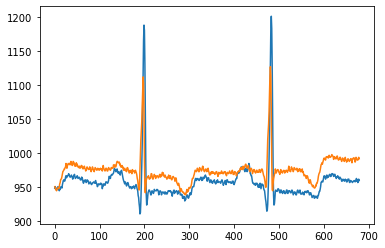

In [7]:
# os.environ["CUDA_VISIBLE_DEVICES"] = '4'
data = (wfdb.rdrecord("../data/mit-bih-arrhythmia-database-1.0.0/100", physical=False)).d_signal

# print(data.d_signal.shape)
atr = wfdb.rdann("../data/mit-bih-arrhythmia-database-1.0.0/101", extension='atr')
# print(atr.sample)
# print(len(atr.symbol))
# print(len([i for i in atr.subtype]))
# print(atr.symbol)
# atr.__dict__
# data.__dict__
sample = atr.sample
[atr.sample[i+1] - atr.sample[i] for i in range(len(atr.sample)-1)]

# plt.plot(data[atr.sample[3]-128:atr.sample[3]+128])
plt.plot(data[sample[4]:sample[6]])
data.shape
wfdb.rdrecord("../data/mit-bih-arrhythmia-database-1.0.0/100").fs

In [8]:
data1 = data[0:3600,:]
max_v = np.max(data1, axis=0)
min_v = np.min(data1, axis=0)
data1_reg = (data1 - min_v)/(max_v - min_v)
sample1_index = [i<3000 for i in sample]
sample1 = sample[sample1_index]
rr_interval = np.array(sample1[1:]) - np.array(sample1[:-1])
median = int(np.median(rr_interval))
print(median)
input_data = []
for i in range(len(sample1)-1):
    if sample1[i]-median//2>0 and sample1[i]+median//2<3600:
        input_data.append(np.pad(data1[sample1[i]-median//2:sample1[i]+median//2,:], pad_width=((int(0.1*median), int(0.1*median)),(int(0.1*median), int(0.1*median))),mode='constant'))

314


In [9]:
data1d = data[:,1]
a = preprocess(data1d, 360)


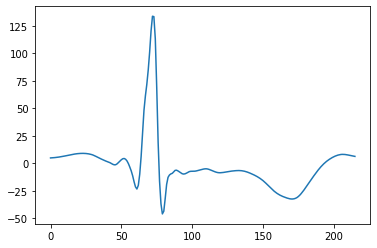

In [10]:
heartbeat_pds = a['ECG_info']['heartbeats']
heartbeat1 = np.array(heartbeat_pds[1])
plt.plot(heartbeat1)

In [11]:

        
def mitdb_aryth_batchiter(batch_size, nums, path, use_last_batch=True):
    '''
    ###INPUT:
    batch_size: int, the batch_size of the iter
    nums: List, the ecg data sets to subsection
    path: str, the ecg data storage path
    use_last_batch: bool, if True, the final batch of an ecg data is not same as the batch_size; else, drop the final ecg data batch.

    ###FUNCTION:
    read a single ecg data, realize automatic segmentation
    a single heartbeat is consist of 258 
    
    ###OUTPUT:
    batch_x: 
    shape (batch_size x length x dimension, precisely equals to batch_size x 258 x 2)
    type  tensor.FloatTensor
    batch_y: shape (batch_size) 
    type  tensor.LongTensor
    
    '''
    # default dictionary for aryth classify
    default_dict_ecg = defaultdict(lambda: 4)
    dict_ecg_num =  {"N":0, "L":0, "R":0, "e":0, "j":0,      #"B":0,
                    "A":1, "a":1, "J":0, "S":1, 
                    "V":2, "E":2,                   #"r":2,
                    "F":3,                          #"n":3,
                    "/":4, "f":4, "Q":4, "|":4             #"?":4
                    }  
    for i in dict_ecg_num:
        default_dict_ecg[i] = dict_ecg_num[i]

    for num in nums:
        total_path = path + '/' + str(num)
        data = (wfdb.rdrecord(total_path, physical=False)).d_signal
        # data = std_standard(data)
        atr = wfdb.rdann(total_path, extension="atr")
        atr_sample = atr.sample
        atr_symbol = atr.symbol
        R_times = len(atr_symbol)
        batch_x = []
        batch_y = []
        count = 0
        for i in range(R_times - 2):
            if atr_sample[i+1] - atr_sample[i]>258:
                batch_x.append(torch.FloatTensor(data[atr_sample[i+1]-127:atr_sample[i+1]+127]).unsqueeze(dim=0))
                batch_y.append(default_dict_ecg[atr_symbol[i+1]])
                count += 1
                if count == batch_size:
                    yield torch.cat(batch_x,dim=0), torch.LongTensor(batch_y)
                    count = 0
                    batch_x = []
                    batch_y = []
        if  count is not 0 and use_last_batch:
            yield torch.cat(batch_x,dim=0), torch.LongTensor(batch_y)

In [12]:
path = "../data/mit-bih-arrhythmia-database-1.0.0"
train_iter = mitdb_aryth_batchiter(10, [100,101] , path)
for x, y in train_iter:
    print(x.shape, y.shape)

torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Size([10])
torch.Size([10, 254, 2]) torch.Siz

In [13]:
class SE_Block(nn.Module):
    def __init__(self, ch_in, reduction=16):
        super(SE_Block, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(ch_in, ch_in // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(ch_in // reduction, ch_in, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _= x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)
    
class MultiScaleResBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, stride=1, padding=0, dilation=1, num_groups=4, attention=True, reduction=16):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size, padding=dilation*(kernel_size-1)//2, dilation=dilation)
        self.gn1 = nn.GroupNorm(num_groups, in_channels)
        self.conv2 = nn.Conv1d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size, padding=dilation*(kernel_size-1)//2, dilation=dilation)
        self.gn2 = nn.GroupNorm(num_groups, in_channels)
        if attention:
            self.seattn = SE_Block(in_channels, reduction)
        
    def forward(self,x):
        y = self.conv1(x)
        y = self.gn1(y)
        y = F.relu(y)
        y = self.conv2(y)
        y = self.gn2(y)
        y = F.relu(y)
        y = self.seattn(y)
        y+=x
        return y
class JointModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, conv_kernel=1):
        super().__init__()
        self.maxpool = nn.MaxPool1d(kernel_size=kernel_size, stride=stride)
        self.conv = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=conv_kernel)
            
    def forward(self, x):
        return F.relu(self.conv(self.maxpool(x)))

        
class MultiScaleRes(nn.Module):
    def __init__(self, input_channels, num_class):
        super().__init__()
        self.conv_init = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=5)
        self.maxpool = nn.MaxPool1d(kernel_size=2,stride=2)
        self.res1 = nn.Sequential(MultiScaleResBlock(64, 1), MultiScaleResBlock(64, 1), JointModule(64, 128), MultiScaleResBlock(128, 1), MultiScaleResBlock(128, 1), JointModule(128, 256), MultiScaleResBlock(256, 1), MultiScaleResBlock(256, 1), nn.Conv1d(256, num_class, kernel_size=1), nn.AdaptiveAvgPool1d(1))
        self.res2 = nn.Sequential(MultiScaleResBlock(64, 3), MultiScaleResBlock(64, 3), JointModule(64, 128), MultiScaleResBlock(128, 3), MultiScaleResBlock(128, 3), JointModule(128, 256), MultiScaleResBlock(256, 3), MultiScaleResBlock(256, 3), nn.Conv1d(256, num_class, kernel_size=1), nn.AdaptiveAvgPool1d(1))
        self.res3 = nn.Sequential(MultiScaleResBlock(64, 3, dilation=1), MultiScaleResBlock(64, 3, dilation=1), JointModule(64, 128), MultiScaleResBlock(128, 3, dilation=2), MultiScaleResBlock(128, 3, dilation=2), JointModule(128, 256), MultiScaleResBlock(256, 3, dilation=4), MultiScaleResBlock(256, 3, dilation=4), nn.Conv1d(256, num_class, kernel_size=1), nn.AdaptiveAvgPool1d(1))
        
        self.avgpool1d = nn.AdaptiveAvgPool1d(1)
    def forward(self, x):
        y = self.conv_init(x)
        y = F.relu(y)
        y = self.maxpool(y)
        y1 = self.res1(y)
        y2 = self.res2(y)
        y3 = self.res3(y)
        Y = torch.cat([y1, y2, y3], dim=2)
        Y = self.avgpool1d(Y)
        return Y.squeeze(2)

class ClusterML(nn.Module):
    def __init__(self, nclass, embedding_size):
        self.centroid_list = nn.Parameter()
        self.flags = [0 for i in range(nclass)]
        

In [14]:
msc = MultiScaleRes(1, 3)
x = torch.randn([10,1,100])
msc(x).size()

torch.Size([10, 3])

In [15]:
class TestIter():
    def __init__(self, a):
        self.a = a
    
    def testiter(self):
        for i in range(10):
            yield 1
ti = TestIter(3)
for i in ti.testiter():
    print(i)

1
1
1
1
1
1
1
1
1
1


In [16]:
a = torch.randn(10,20)
index = [1,2,3]
a[index].type()
20//6

3

In [17]:
import random
import torch
class Data_iter():
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.length = self.data.size(0)
        self.idx = [i for i in range(self.length)]
    def shuffle(self,seed=None):
        if  seed is not None:
            random.seed(seed)
        random.shuffle(self.idx)
    def train_iter(self, total_size, batch_size):
        for i in range((total_size+batch_size-1)//batch_size):
            if batch_size*(1+i)-1 < total_size:
                batch_idx = self.idx[i*batch_size:(1+i)*batch_size]
            else:
                batch_idx = self.idx[i*batch_size:total_size]

            yield self.data[batch_idx], self.labels[batch_idx]

dataT = torch.randn(20,3)            
labelT = torch.LongTensor([i for i in range(10)])
data_iter = Data_iter(dataT, labelT)
data_iter.shuffle()
for i,j in data_iter.train_iter(10, 3):
    print(i.size())
         

IndexError: index 13 is out of bounds for dimension 0 with size 10

In [7]:
DS1 = [101, 106, 108, 109, 112, 114, 115, 116, 118, 119,
122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]
DS2 = [100, 103, 105, 111, 113, 117, 121, 123, 200, 202,
210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]
for i in range(len(atr.symbol)-2):
    input_sig = data.d_signal[atr.sample[i]:atr.sample[i+2]][:]

In [8]:
# numpy归一化
# 平均归一化
def mean_standard(x):
    Min = np.min(x)
    Max = np.max(x)
    return (x-Min)/(Max-Min)
# 标准化归一化
def std_standard(x):
    mu = np.expand_dims(np.average(x, axis=1), axis=1)
    sigma = np.expand_dims(np.std(x, axis=1), axis=1)
    x = (x - mu)/ sigma
    return x
# sigmoid归一化
def sigmoid_standard(x):
    return 
def arrhythmia_iter(num, path):
    default_dict_ecg = defaultdict(lambda: 4)
    dict_ecg_num =  {"N":0, "L":0, "R":0, "e":0, "j":0,      #"B":0,
                    "A":1, "a":1, "J":0, "S":1, 
                    "V":2, "E":2,                   #"r":2,
                    "F":3,                          #"n":3,
                    "/":4, "f":4, "Q":4, "|":4             #"?":4
                    }  
    for i in dict_ecg_num:
        default_dict_ecg[i] = dict_ecg_num[i]
    total_path = path + '/' + str(num)
    data = (wfdb.rdrecord(total_path, physical=False)).d_signal
    # data = std_standard(data)
    atr = wfdb.rdann(total_path, extension="atr")
    atr_sample = atr.sample
    atr_symbol = atr.symbol
    R_times = len(atr_symbol)
    for i in range(R_times - 2):
        yield data[atr_sample[i]:atr_sample[i+2]][:].transpose(), default_dict_ecg[atr_symbol[i+1]]
default_dict_ecg = defaultdict(lambda: 4)
dict_ecg_num =  {"N":0, "L":0, "R":0, "e":0, "j":0,      #"B":0,
                "A":1, "a":1, "J":0, "S":1, 
                "V":2, "E":2,                   #"r":2,
                "F":3,                          #"n":3,
                "/":4, "f":4, "Q":4, "|":4             #"?":4
                }  
for i in dict_ecg_num:
    default_dict_ecg[i] = dict_ecg_num[i]
model = MultiScaleRes(2, 5)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)   
device = torch.device("cuda:4")
if torch.cuda:
    model = model.cuda()
                

In [9]:
path = "../data/mit-bih-arrhythmia-database-1.0.0"
for x,y in arrhythmia_iter(100, path):
    print(y)

0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [7]:

def arrhythmia_train(epoch, train_num, path):
    
    loss_list = [sys.maxsize]
    for i in range(epoch):
        t = time.time()
        model.train()
        optimizer.zero_grad()
        # 训练一个epoch
        print(i)
        for j in train_num:
            # 在一个整条序列中
            for x,y in arrhythmia_iter(j, path):
                # 每一个心拍
                x = std_standard(x)
                x = torch.FloatTensor(x)
                label = default_dict_ecg[y]
                label = torch.LongTensor([label])
               
                x.unsqueeze_(0)
                x, label = x.cuda(), label.cuda()
                output = model(x)   
                # print(label, output)          
                loss_train = F.cross_entropy(output, label)
                loss_train.backward()
                optimizer.step()
                

In [12]:
DS1 = [101, 106, 108, 109, 112, 114, 115, 116, 118, 119,
122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]
DS2 = [100, 103, 105, 111, 113, 117, 121, 123, 200, 202,
210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]
path = "../data/mit-bih-arrhythmia-database-1.0.0"
arrhythmia_train(20, DS1,path)


NameError: name 'arrhythmia_train' is not defined

In [7]:
clone = MultiScaleRes(2, 5)
clone.load_state_dict(torch.load("my_model.pth"))

<All keys matched successfully>

In [10]:
path_save = "./my_model.pth"
torch.save(model.state_dict(),path_save)

In [ ]:
test_pred = torch.Tensor([[1,0,0],[0,1,0]])
label = torch.LongTensor([0,1])
loss = F.cross_entropy(test_pred, label)
loss

tensor(0.5514)

In [8]:
import sklearn
def accuracy(output, labels):
    preds = output.max(1)[1].cpu().numpy()
    labels = labels.cpu().numpy()
    accuracy_score = (sklearn.metrics.accuracy_score(labels, preds))

    return accuracy_score

In [21]:
clone.eval()
path = "../data/mit-bih-arrhythmia-database-1.0.0"
pred = np.array([])
labels = []
clone.cuda()
for x,y in arrhythmia_iter(103, path):
    x = std_standard(x)
    x = torch.FloatTensor(x)
    label = default_dict_ecg[y]
    
    
    x.unsqueeze_(0)
    x = x.cuda()
    output = clone(x)
    output = output.squeeze(0)
    pred = np.append(pred, output.max(1)[1].cpu().numpy())
    labels.append(label)

In [38]:
a = torch.randn(6,3)
a.max(1)[1]

tensor([2, 0, 2, 1, 1, 2])

In [20]:
from sklearn.metrics import confusion_matrix
print(len(labels))
print(len(pred))
print(pred)
cm = confusion_matrix(pred, labels, labels=None, sample_weight=None)
np.unique(labels)
cm

2689
2689
[0. 0. 0. ... 0. 0. 0.]


array([[2504,   41,  123],
       [   0,    0,    0],
       [  21,    0,    0]])

In [18]:
a = torch.Tensor([1,2,3])
a1= a.max(0)[1].numpy()
b= np.array([])
c = np.append(a1,b)
d = a.max(0)[1].numpy()
c = np.append(c, d)
2238/(34+2238)                  

0.9850352112676056

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


0.6666666666666666	0.3333333333333333
0.25	0.75


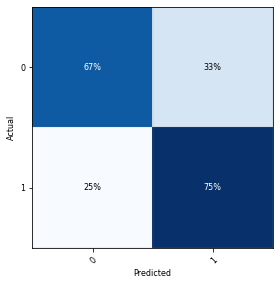

In [1]:
import torch
a = torch.randn(10,2)
b = [1,1,1,1,1,0,0,0,0,0]
path = './'
from utils.utils import save_confusion_matrix

save_confusion_matrix(a, b, path)



In [39]:
if not None:
    print(1)

1


In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
cm = confusion_matrix(pred, labels, labels=None, sample_weight=None)
labels_name = ["0","1", "2","3","4"]
def plot_Matrix(cm, classes, title=None,  cmap=plt.cm.Blues):
    plt.rc('font',family='Times New Roman',size='8')   # 设置字体样式、大小
    # plt.colorbar()
    # 按行进行归一化
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
    str_cm = cm.astype(np.str).tolist()
    for row in str_cm:
        print('\t'.join(row))
    # 占比1%以下的单元格，设为0，防止在最后的颜色中体现出来
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if int(cm[i, j]*100 + 0.5) == 0:
                cm[i, j]=0

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax) # 侧边的颜色条带
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # 通过绘制格网，模拟每个单元格的边框
    ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.2)
    ax.tick_params(which="minor", bottom=False, left=False)

    # 将x轴上的lables旋转45度
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # 标注百分比信息
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if int(cm[i, j]*100 + 0.5) > 0:
                ax.text(j, i, format(int(cm[i, j]*100 + 0.5) , fmt) + '%',
                        ha="center", va="center",
                        color="white"  if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig('cm.jpg', dpi=300)
    
    plt.show()

In [8]:
from models import MultiScaleConv1dBlock
mb = MultiScaleConv1dBlock(10,16,[3,5,7])
a = torch.randn(5,10,4)
b = mb(a)
b.size()

torch.Size([5, 48, 4])

In [40]:
plot_Matrix(cm, labels_name )

Normalized confusion matrix
nan	nan	nan	nan
nan	nan	nan	nan
nan	nan	nan	nan
0.9850352112676056	0.014524647887323943	0.00044014084507042255	0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


ValueError: cannot convert float NaN to integer

In [9]:
class SplitAttnConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True, cardinal=1, radix=2, reduction=4):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels * radix, kernel_size, stride, padding, dilation, groups=cardinal * radix, bias=bias),
            nn.BatchNorm1d(out_channels * radix),
            nn.ReLU()
        )
        self.att = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(out_channels, out_channels//reduction, 1 , groups=cardinal),
            nn.ReLU(),
            nn.Conv1d(out_channels//reduction, out_channels * radix, 1, group=cardinal)
        )
        self.out_channels = out_channels
        self.radix = radix
        self.cardinal = cardinal

    def forward(self, x):
        x = self.conv1(x)

        if self.radix > 1:
            splited = torch.split(x, x.size(1)//self.radix, dim=1)
            gap = sum(splited)
        else:
            gap = x

        atten = self.att(gap)

        if self.radix > 1:
            atten = atten.view(x.szie(0), self.out_channels, self.radix, -1).transpose(1,2)
            atten = F.softmax(atten, dim=1)
            atten = atten.reshape(x.size(0), -1, 1)
        else:
            atten = torch.sigmoid(atten)
        
        if self.radix > 1:
            atten = torch.split(atten, x.size(1)//self.radix, dim=1)
            out = sum([att * split for (att, split) in zip(atten,splited)])
        else: 
            out = atten * x
        return out.contiguous()


NameError: name 'nn' is not defined

In [44]:
class SK_MultiScaleConv1dBlock(nn.Module):
    '''
    docstring
    
    '''
    def __init__(self, in_channels, out_channels, rate, input_scales = [3,5,7,11,13]):
        '''
        多尺度一元时序卷积模块
        Multiscale conv1d sequential convolution module
        INPUT:
        in_channels: Int, the numbers of the input channels 
        out_channels: Int, the numbers of the out channels 
        input_scales: List, 
        '''
        super().__init__()
        min_length = 32
        self.scales = len(input_scales)
        self.conv_array = []
        self.linear_array = []
        z_channels = max(min_length, int(rate * out_channels))
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.bn = nn.BatchNorm1d(out_channels)
        self.linear_sum = nn.Linear(out_channels, z_channels)
        self.linear_split = nn.Linear(z_channels, self.scales * out_channels)        
        for i in input_scales:
            self.conv_array.append(nn.Conv1d(in_channels, out_channels,kernel_size=i, padding=(i-1)//2))
            

    def forward(self, x):
        N = x.size(0)
        y = []
        for conv in self.conv_array:
            y.append(torch.unsqueeze(conv(x), dim=1))
        y_cat = torch.cat(y, dim=1)
        y_sum = torch.sum(y_cat, dim=1)
        gap = self.gap(y_sum)
        output = self.bn(self.linear_sum(gap))
        split = self.linear_split(output)
        split = torch.reshape(split, (N, self.scales, -1))
        split = F.softmax(split, dim=1)
        split = torch.unsqueeze(split, dim=3)
        return torch.sum(split * y_cat, dim=1)

In [51]:

DS1 = [101, 106, 108, 109, 112, 114, 115, 116, 118, 119,
122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]
DS2 = [100, 103, 105, 111, 113, 117, 121, 123, 200, 202,
210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]
DS = DS1 + DS2
random.shuffle(DS1 + DS2)
DS1

[101,
 106,
 108,
 109,
 112,
 114,
 115,
 116,
 118,
 119,
 122,
 124,
 201,
 203,
 205,
 207,
 208,
 209,
 215,
 220,
 223,
 230]

In [45]:
sknet = SK_MultiScaleConv1dBlock(10,20,0.4)
y = torch.randn(5,10,4)
l = sknet(y)

RuntimeError: size mismatch, m1: [100 x 1], m2: [20 x 32] at /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/TH/generic/THTensorMath.cpp:41

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score  


testa = torch.randn(10,3)
testa.cuda()

In [43]:
import torch
a = torch.Tensor([[1,1,2,2],[3,3,4,4]])
a.unsqueeze_(0)
aa = torch.cat([a,a],dim=0)
print(torch.sum(aa,dim=1).size() )
b = torch.Tensor([1,1,1,2,2,2,3,3,3,4,4,4])
c = b.view(2,2,-1).transpose(0,1)
print(c)
c = F.softmax(c, dim=0)
c
int(3.5)
d = nn.AdaptiveAvgPool1d(1)(aa)
d.size()
# torch.randn(2,3,4,1) * torch.randn(2,3,4,5)

torch.Size([2, 4])
tensor([[[1., 1., 1.],
         [3., 3., 3.]],

        [[2., 2., 2.],
         [4., 4., 4.]]])


torch.Size([2, 2, 1])

In [1]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np




/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
writer = SummaryWriter(log_dir = 'logs')
for x in range(1, 101):
    writer.add_scalar('y=2x', x, 2*x)
writer.close()

2022-07-13 12:27:11.793607: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
import numpy as np
def np_normlize(nparray):
    
    return (nparray - np.min(nparray, axis=0)) /(np.max(nparray, axis=0) - np.min(nparray, axis=0))
                                                 
a = np.array([[1,2], [3,4], [5,6]])
print(a.shape )
np_normlize(a)

(3, 2)


array([[0. , 0. ],
       [0.5, 0.5],
       [1. , 1. ]])

In [8]:
import torch.nn as nn
import torch 
model = nn.Conv1d(1,2,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-5)
print(type(optimizer).__name__)

Adam


In [21]:
from tqdm import tqdm 
from time import sleep 
def easy_iter():
    for i in range(10):
        yield i
iter = easy_iter() 
with tqdm(iterable=easy_iter() ,total=10):
    for i in easy_iter():
        

  0%|          | 0/10 [00:00<?, ?it/s]
